In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import math
from sklearn.metrics import mean_squared_error
import seaborn as sns
import rasterio


# Useful functions

In [53]:
def inverse_scaling(scaled_data, original_min, original_max):
    return scaled_data * (original_max - original_min) + original_min

In [54]:
def plot_diag(x,y,name):
    plt.figure(figsize=(14,7))
    plt.bar(x, y)
    plt.xlabel('Date')
    plt.ylabel(f'{name}')
    plt.title(f'{name} over Time')
    plt.show()

In [55]:
def check_time_continuity(df):
    for location in df['loc'].unique():
        loc_df = df[df['loc'] == location]  # select the current location only
        loc_df['date'] = pd.to_datetime(loc_df['date']) 
        loc_df = loc_df.sort_values('date')

        # calculate difference between two dates
        loc_df['time_diff'] = loc_df['date'].diff().dt.days

        # if the difference > 1 then print it out
        if any(loc_df['time_diff'] > 1):
            print(f"Location {location} has discontinuous time data at the following dates:")
            print(loc_df[loc_df['time_diff'] > 1]['date'])
            return False

    print("All locations have continuous time data.")
    return True

# Read data

In [56]:
folder_path = '/Users/yz6622/Desktop/IRP/dataset/swiss_station/Preprocessed_data/'

In [57]:
file_path = folder_path + 'train.csv'

# read data
df = pd.read_csv(file_path)

print(df.head())

         date        HS  station_SWE  Sturm_SWE (cm)  deltaSnow_SWE (cm)  \
0  2003-09-30  0.000000     0.000000        0.000000            0.000000   
1  2003-10-01  0.005578     0.368191        0.002497            0.002397   
2  2003-10-02  0.005129     0.351574        0.002309            0.002397   
3  2003-10-03  0.004589     0.395334        0.002077            0.002397   
4  2003-10-04  0.005668     0.395153        0.002585            0.002397   

            loc  precipitation      snowfall  solar_radiation  temperature  \
0  canada_3A25P   3.662044e-08  3.663723e-08         0.032299     0.522216   
1  canada_3A25P   3.662044e-08  3.663723e-08         0.030108     0.555290   
2  canada_3A25P   5.450587e-04  3.663723e-08         0.029086     0.508123   
3  canada_3A25P   1.820036e-05  3.663723e-08         0.028209     0.517716   
4  canada_3A25P   5.452784e-05  3.663723e-08         0.027096     0.476645   

       rain     month  
0  0.062383  0.727273  
1  0.062383  0.818182  
2 

In [58]:
# set the datetime and sort the values
df = df.sort_values(by="date")
df.reset_index(drop=True, inplace=True)

In [60]:
file_path = folder_path + 'test.csv'

# read data
df_test = pd.read_csv(file_path)

print(df_test.head())

         date        HS  station_SWE  Sturm_SWE (cm)  deltaSnow_SWE (cm)  \
0  2008-10-02  0.010750     2.788030        0.004870            0.012337   
1  2008-10-03  0.009824     2.538696        0.004473            0.011273   
2  2008-10-04  0.008898     2.111562        0.004072            0.010210   
3  2008-10-05  0.007971     1.740292        0.003666            0.009147   
4  2008-10-06  0.007045     1.235040        0.003257            0.008084   

            loc  precipitation      snowfall  solar_radiation  temperature  \
0  canada_4B16P   3.662044e-08  3.663723e-08         0.017846     0.512300   
1  canada_4B16P   2.580432e-01  3.663723e-08         0.004604     0.488581   
2  canada_4B16P   1.571692e-01  3.663723e-08         0.005102     0.490934   
3  canada_4B16P   2.680880e-01  2.984925e-02         0.006188     0.418342   
4  canada_4B16P   1.960084e-02  6.193011e-03         0.014789     0.422286   

       rain     month  
0  0.062383  0.818182  
1  0.314164  0.818182  
2 

# Reverse the data

In [61]:
# inverse all the features
df['HS'] = inverse_scaling(df['HS'], 0.0, 555.7083333333334)
df['precipitation'] = inverse_scaling(df['precipitation'], 0, 0.0508635304868221)
df['snowfall'] = inverse_scaling(df['snowfall'], 0, 0.0508402287960052)
df['solar_radiation'] = inverse_scaling(df['solar_radiation'], 0, 22261948.0)
df['temperature'] = inverse_scaling(df['temperature'], -29.88636779785156, 39.6531982421875)
df['rain'] = inverse_scaling(df['rain'], 0, 0.0488765742629765)
df['month'] = inverse_scaling(df['month'], 1, 12)

In [62]:
# inverse all the features
df_test['HS'] = inverse_scaling(df_test['HS'], 0.0, 555.7083333333334)
df_test['precipitation'] = inverse_scaling(df_test['precipitation'], 0, 0.0508635304868221)
df_test['snowfall'] = inverse_scaling(df_test['snowfall'], 0, 0.0508402287960052)
df_test['solar_radiation'] = inverse_scaling(df_test['solar_radiation'], 0, 22261948.0)
df_test['temperature'] = inverse_scaling(df_test['temperature'], -29.88636779785156, 39.6531982421875)
df_test['rain'] = inverse_scaling(df_test['rain'], 0, 0.0488765742629765)
df_test['month'] = inverse_scaling(df_test['month'], 1, 12)

# Add snow class

In [84]:
location = df['loc'].unique()

In [85]:
lonlat = {}
lonlat['canada_3A25P'] = [50.1543, -123.4361]
lonlat['canada_3A20P'] = [50.13706, -123.10289]
lonlat['canada_4A30P'] = [56.43686, -125.7417]
lonlat['canada_4B16P'] = [55.86165, -127.69842]
lonlat['norway_121420'] = [60.681, 8.004]
lonlat['norway_62420'] = [60.866, 6.473]
lonlat['norway_850'] = [59.968, 10.547]
lonlat['norway_77240'] = [61.366, 6.906]
lonlat['norway_211270'] = [59.619, 7.427]
lonlat['gps2'] = [46.8297, 9.8094]
lonlat['gps1'] = [46.8297, 9.8094]
lonlat['wfj'] = [46.8297, 9.8094]
lonlat['klo'] = [46.8636, 9.8881]

In [88]:
snow_class = {}
for _, key in enumerate(lonlat):
    lon = lonlat[f'{key}'][1]
    lat = lonlat[f'{key}'][0]

    # open the class scheme file
    with rasterio.open('/Users/yz6622/Desktop/IRP/dataset/SnowClass_GL_50km_0.50degree_2021_v01.0.tif') as src:
        # change the lat and lon into the pixel and pixel
        py, px = src.index(lon, lat)
        # get the corresponding values
        snow_class_value = src.read(1)[py, px]

    print(f'The snow classification at {key} is:', snow_class_value)
    snow_class[f'{key}'] = snow_class_value

The snow classification at canada_3A25P is: 3
The snow classification at canada_3A20P is: 3
The snow classification at canada_4A30P is: 2
The snow classification at canada_4B16P is: 6
The snow classification at norway_121420 is: 1
The snow classification at norway_62420 is: 3
The snow classification at norway_850 is: 6
The snow classification at norway_77240 is: 3
The snow classification at norway_211270 is: 1
The snow classification at gps2 is: 1
The snow classification at gps1 is: 1
The snow classification at wfj is: 1
The snow classification at klo is: 1


In [89]:
df['snow_class'] = df['loc'].map(snow_class)
df_test['snow_class'] = df_test['loc'].map(snow_class)

# Data Analysis

In [77]:
df.describe()

,HS,station_SWE,Sturm_SWE (cm),deltaSnow_SWE (cm),precipitation,snowfall,solar_radiation,temperature,rain,month
count,24967.000000,24967.000000,24967.000000,24967.000000,24967.000000,2.496700e+04,2.496700e+04,24967.000000,24967.000000,24967.000000
mean,75.132089,26.404355,0.115218,0.134004,0.002420,1.548736e-03,2.287060e+06,0.472694,0.003866,6.509793
std,93.397249,38.330831,0.152658,0.179284,0.004879,3.999572e-03,3.273685e+06,8.907366,0.002636,3.498488
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-26.573700,0.000000,1.000000
25%,1.444188,0.103798,0.001941,0.000885,0.000011,1.862645e-09,1.597700e+05,-5.304642,0.003050,3.000000
50%,34.083333,9.392897,0.046467,0.047496,0.000427,9.639188e-06,1.051460e+06,-0.257416,0.003055,6.000000
75%,120.816667,38.716316,0.177479,0.213050,0.002421,9.819604e-04,2.703185e+06,6.533783,0.003362,10.000000
max,555.708333,242.906696,1.000000,1.000000,0.050864,5.084023e-02,2.226195e+07,39.653198,0.048877,12.000000


In [78]:
df_test.describe()

,HS,station_SWE,Sturm_SWE (cm),deltaSnow_SWE (cm),precipitation,snowfall,solar_radiation,temperature,rain,month
count,4523.000000,4523.000000,4523.000000,4523.000000,4.523000e+03,4.523000e+03,4.523000e+03,4523.000000,4523.000000,4523.000000
mean,75.706961,27.630937,0.115789,0.136838,2.301039e-03,1.519930e-03,1.944841e+06,-0.158443,0.003781,6.522220
std,96.783767,40.409089,0.157490,0.185294,4.438889e-03,3.694085e-03,2.665798e+06,8.287045,0.002303,3.493423
min,0.000000,0.000000,0.000000,0.000000,9.313225e-10,0.000000e+00,0.000000e+00,-29.886368,0.001990,1.000000
25%,1.000000,0.000000,0.001085,0.000774,2.144463e-05,1.862645e-09,1.185175e+05,-5.919983,0.003050,3.000000
50%,31.900000,9.953551,0.043760,0.056582,4.998613e-04,3.267312e-05,8.106525e+05,-0.803070,0.003054,7.000000
75%,126.395833,42.082835,0.192733,0.225049,2.400717e-03,1.150146e-03,2.452261e+06,6.682358,0.003352,10.000000
max,441.041667,201.321217,0.765659,0.851873,4.254943e-02,4.254144e-02,1.436541e+07,19.613190,0.030149,12.000000


In [63]:
check_time_continuity(df)

Location canada_3A25P has discontinuous time data at the following dates:
6143    2011-10-01
7244    2013-10-02
16454   2018-10-02
Name: date, dtype: datetime64[ns]


/var/folders/5m/bhjjh_l15ng7p2l7swm_bkzh0000gp/T/ipykernel_14202/862849337.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_df['date'] = pd.to_datetime(loc_df['date'])


False

In [64]:
check_time_continuity(df_test)

Location canada_4B16P has discontinuous time data at the following dates:
365   2012-10-02
Name: date, dtype: datetime64[ns]


/var/folders/5m/bhjjh_l15ng7p2l7swm_bkzh0000gp/T/ipykernel_14202/862849337.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_df['date'] = pd.to_datetime(loc_df['date'])


False

## Training set

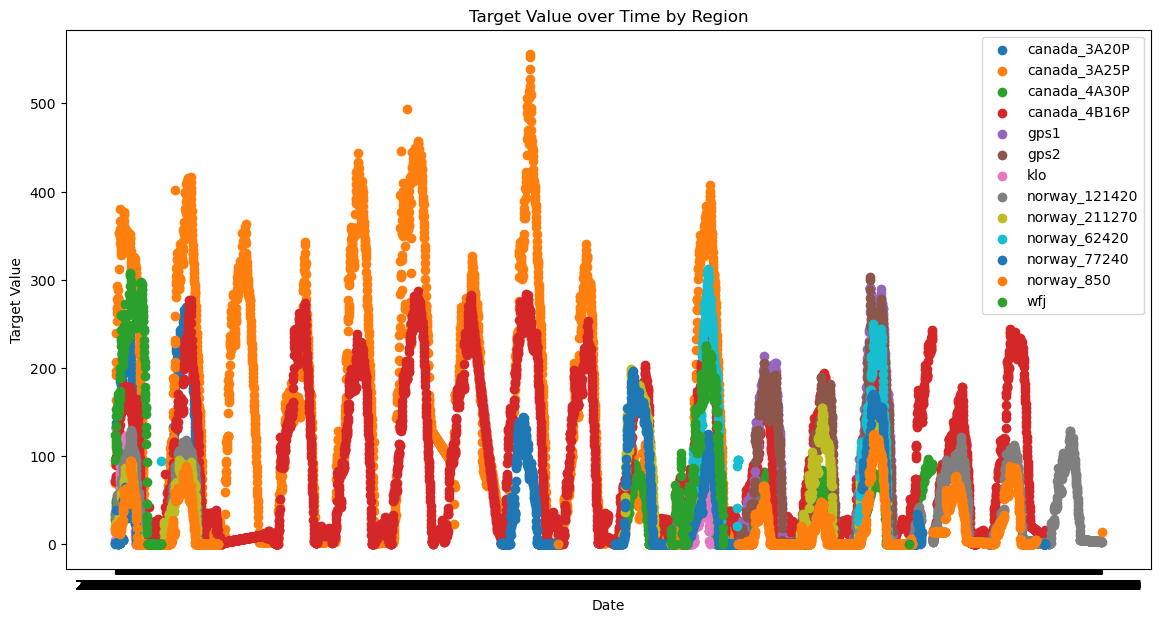

In [70]:
grouped = df.groupby(['loc', 'date']).mean().reset_index()

plt.figure(figsize=(14,7))

for region in grouped['loc'].unique():
    region_data = grouped[grouped['loc'] == region]
    plt.scatter(region_data['date'], region_data['HS'], label=region)
#     plt.plot(region_data['date'], region_data['HS'], label=None)

plt.xlabel('Date')
plt.ylabel('Target Value')
plt.title('Target Value over Time by Region')
plt.legend()
plt.show()


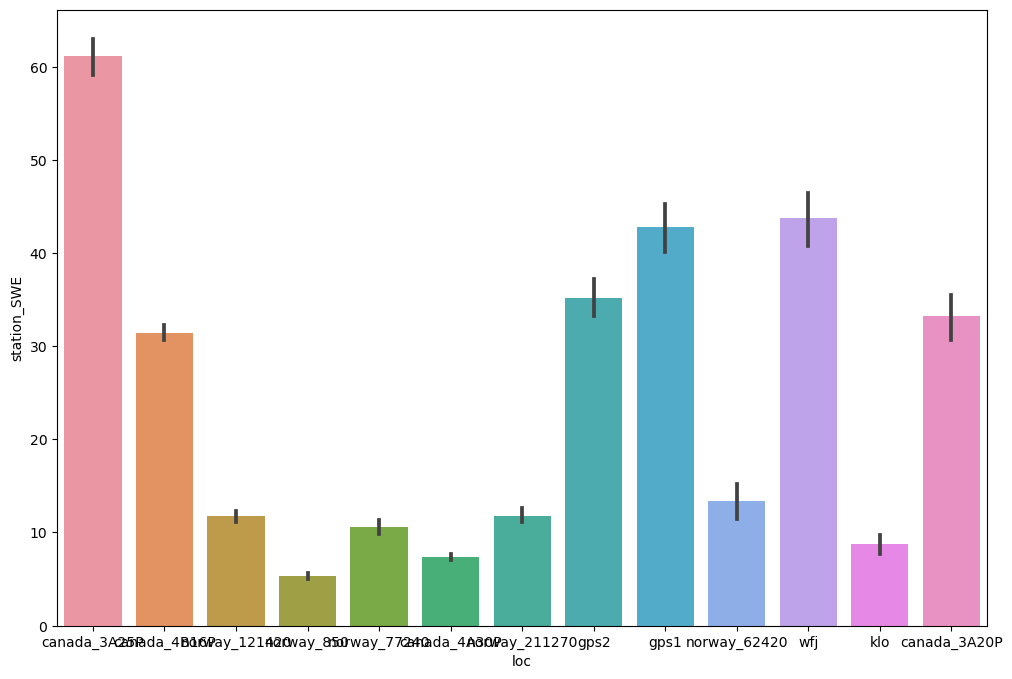

In [76]:
plt.figure(figsize=(12, 8))
sns.barplot(x='loc', y='station_SWE', data=df)
plt.show()
# calculate the mean value of SWE in different regions

Snow depth in different regions varies.

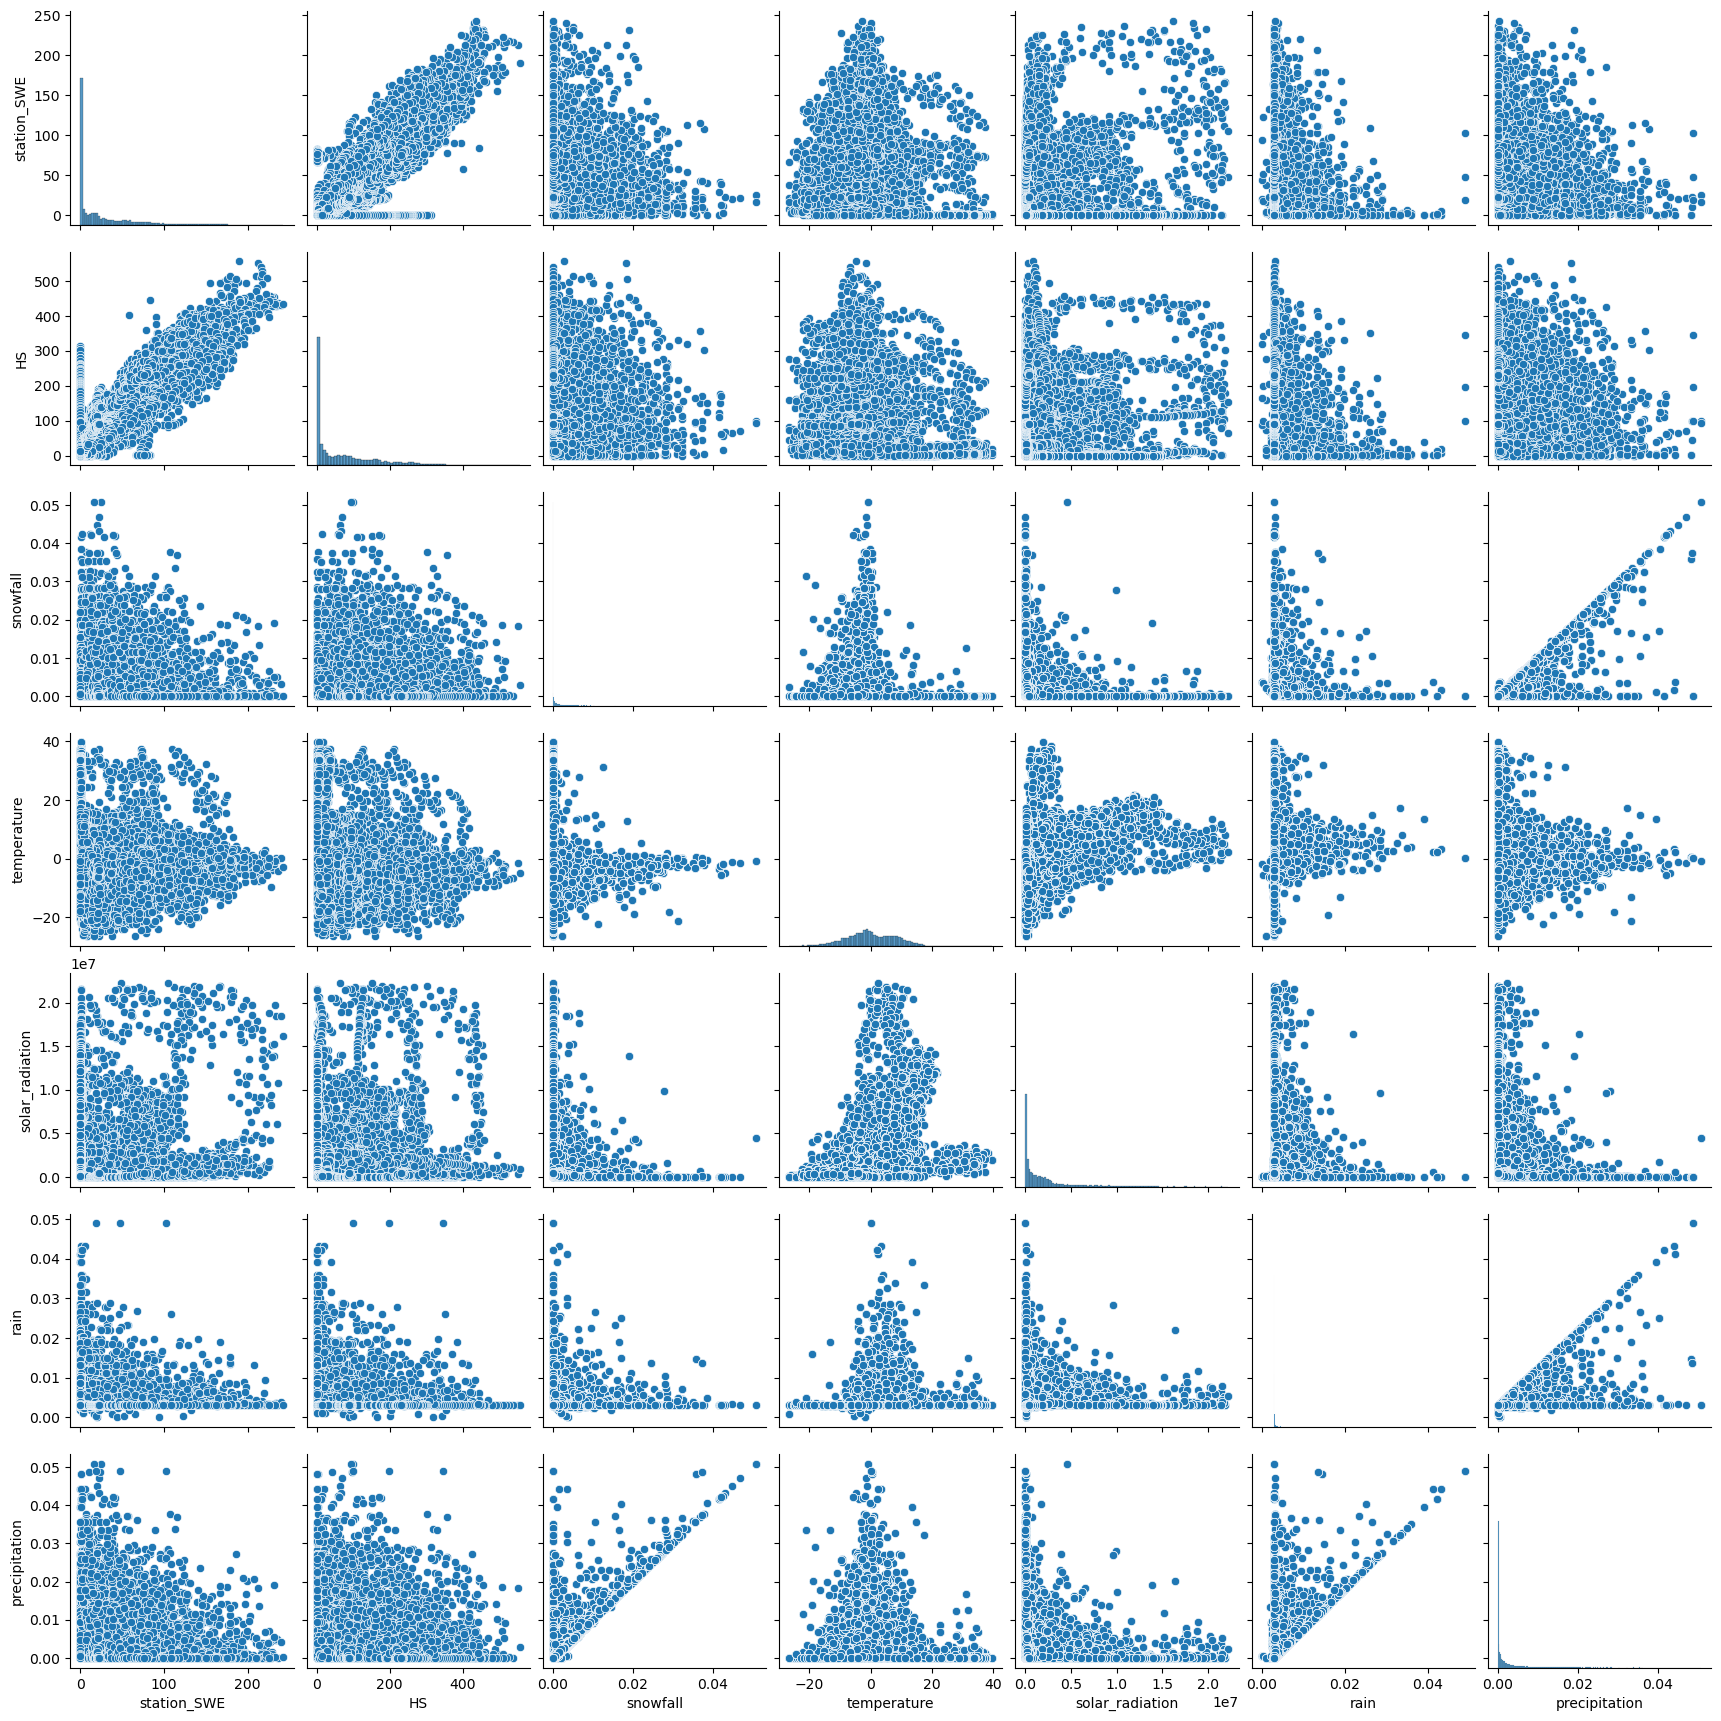

In [71]:
sns.pairplot(df[['station_SWE','HS','snowfall','temperature','solar_radiation','rain','precipitation']])
plt.show()

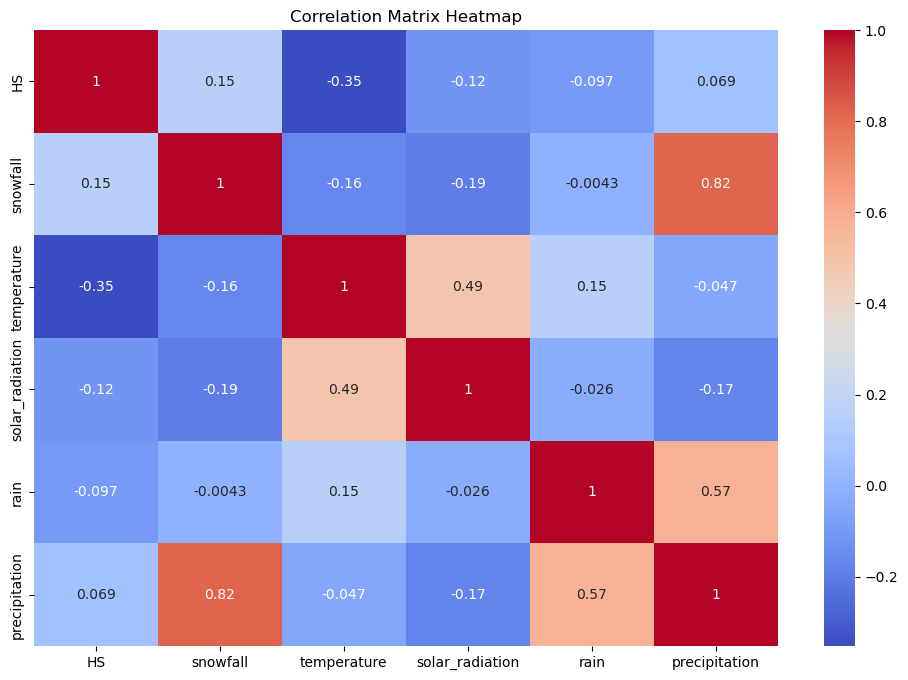

In [72]:
correlation_matrix = df[['HS','snowfall','temperature','solar_radiation','rain','precipitation']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [101]:
df_1 = df[df['snow_class'] == 1]
df_wfj = df[(df['loc'] == 'gps2')| (df['loc'] == 'gps1' )|( df['loc'] == 'wfj')]

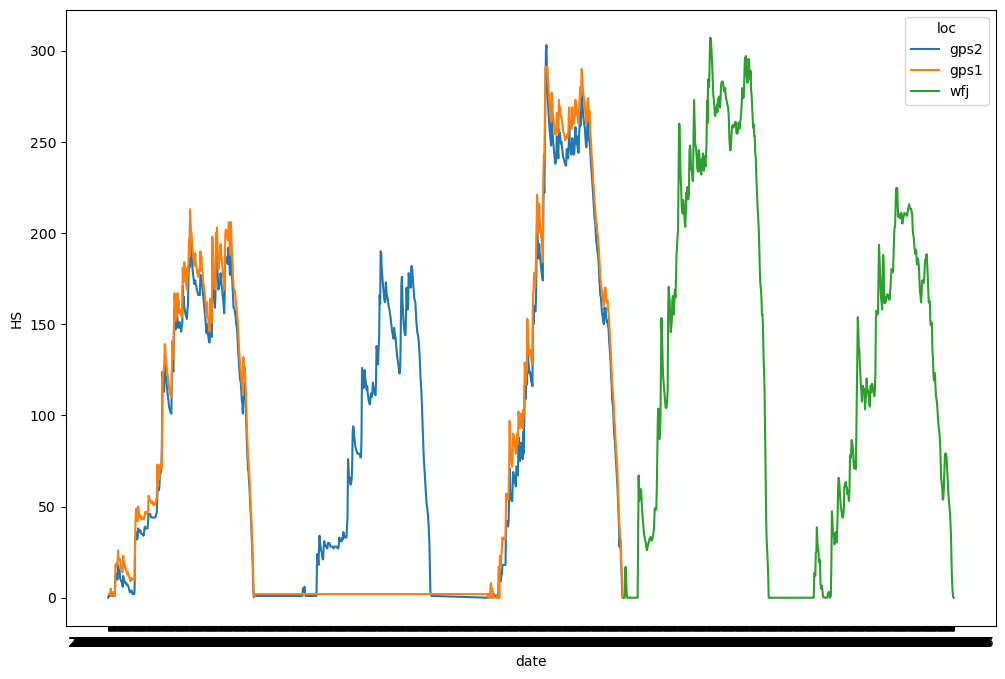

In [103]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='date', y='HS', hue='loc', data=df_wfj)
# sns.lineplot(x='date', y='station_SWE', hue='loc', data=df_wfj)
plt.show()

## Test set

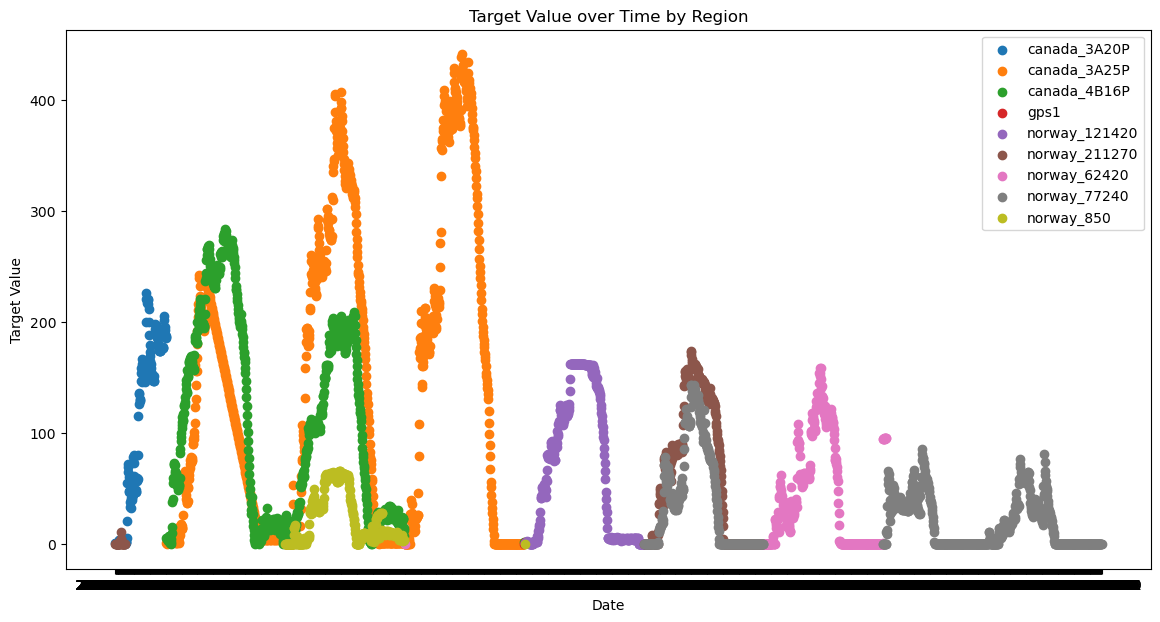

In [104]:
grouped = df_test.groupby(['loc', 'date']).mean().reset_index()

plt.figure(figsize=(14,7))

for region in grouped['loc'].unique():
    region_data = grouped[grouped['loc'] == region]
    plt.scatter(region_data['date'], region_data['HS'], label=region)
#     plt.plot(region_data['date'], region_data['HS'], label=None)

plt.xlabel('Date')
plt.ylabel('Target Value')
plt.title('Target Value over Time by Region')
plt.legend()
plt.show()

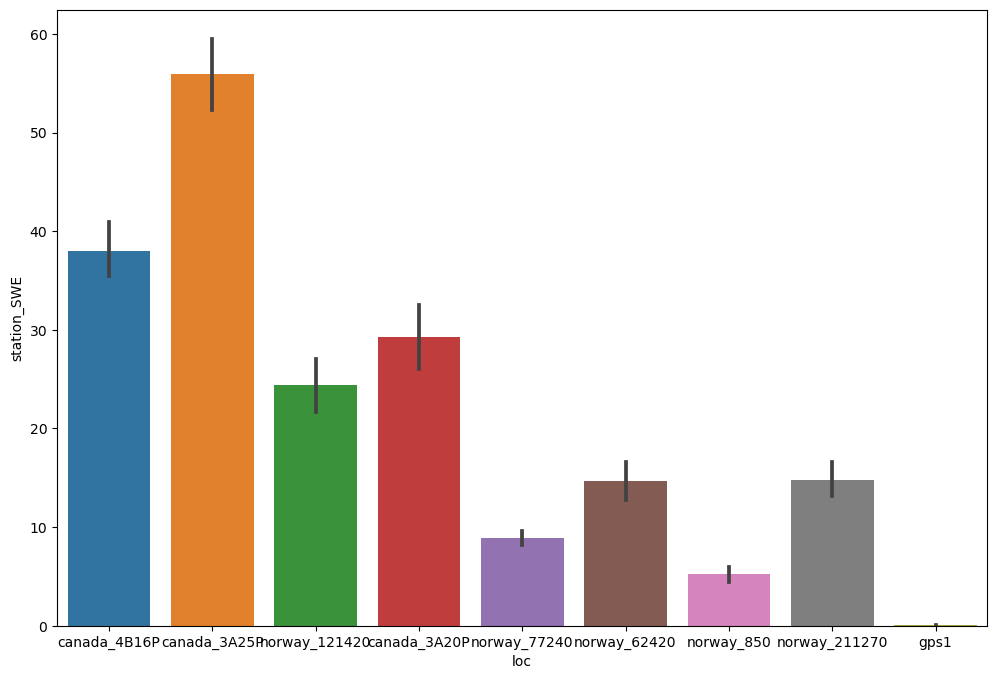

In [105]:
plt.figure(figsize=(12, 8))
sns.barplot(x='loc', y='station_SWE', data=df_test)
plt.show()
# calculate the mean value of SWE in different regions

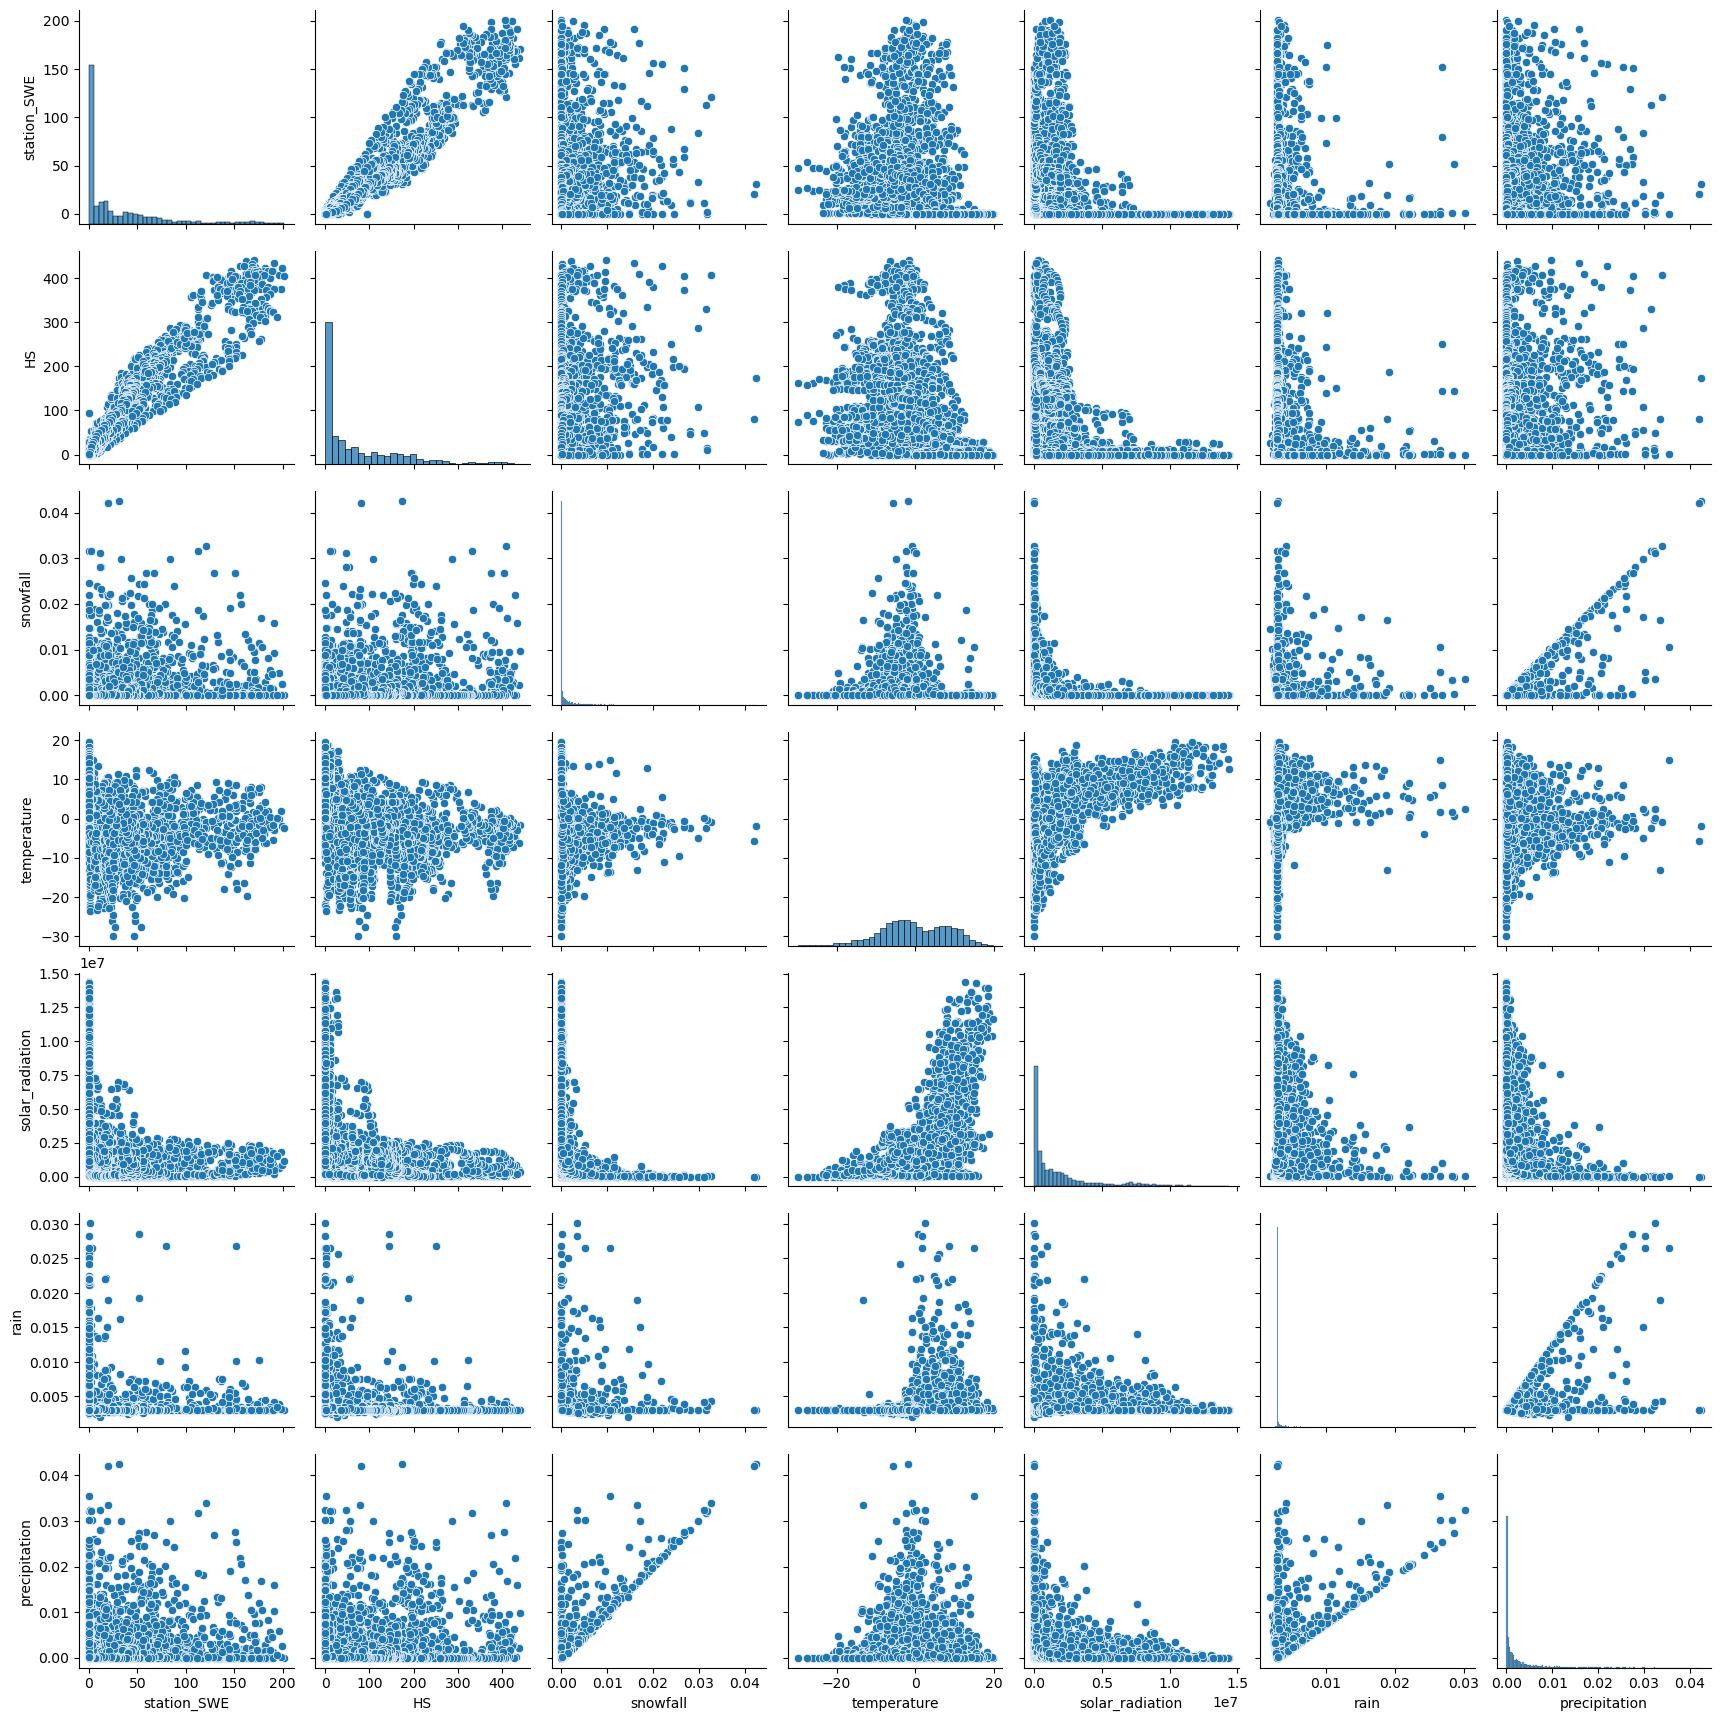

In [106]:
sns.pairplot(df_test[['station_SWE','HS','snowfall','temperature','solar_radiation','rain','precipitation']])
plt.show()

In [114]:
df_1_test = df_test[df_test['snow_class'] == 1]
df_wfj_test = df_test[(df_test['loc'] == 'gps1')]

In [115]:
df_wfj_test

,date,HS,station_SWE,Sturm_SWE (cm),deltaSnow_SWE (cm),loc,precipitation,snowfall,solar_radiation,temperature,rain,month,snow_class
4521,2015-09-30,0.0,0.000000,0.000000,0.000000,gps1,0.000007,0.000004,8.488030e+06,7.151581,0.003053,9.0,1
4522,2015-10-01,2.0,0.036131,0.001607,0.001546,gps1,0.000099,0.000084,8.398962e+06,6.282043,0.003063,10.0,1


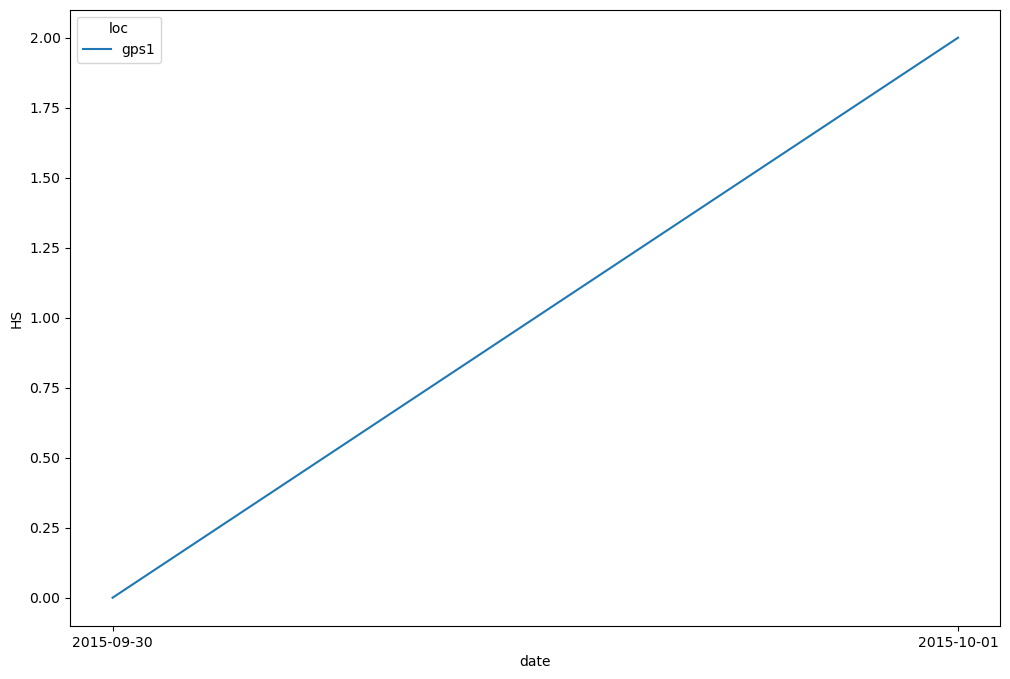

In [116]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='date', y='HS', hue='loc', data=df_wfj_test)
# sns.lineplot(x='date', y='station_SWE', hue='loc', data=df_wfj)
plt.show()